In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from textblob import TextBlob
import string
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.metrics import classification_report, confusion_matrix

# Load the dataset

In [2]:
df = pd.read_json("../data/Appliances_5.json.gz", lines=True)

In [3]:
df.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,5,True,"08 22, 2013",A34A1UP40713F8,B00009W3I4,{'Style:': ' Dryer Vent'},James. Backus,I like this as a vent as well as something tha...,Great product,1377129600,NaN,NaN
1,5,True,"02 8, 2016",A1AHW6I678O6F2,B00009W3PA,{'Size:': ' 6-Foot'},kevin.,good item,Five Stars,1454889600,NaN,NaN
2,5,True,"08 5, 2015",A8R48NKTGCJDQ,B00009W3PA,{'Size:': ' 6-Foot'},CDBrannom,Fit my new LG dryer perfectly.,Five Stars,1438732800,NaN,NaN
3,5,True,"04 24, 2015",AR3OHHHW01A8E,B00009W3PA,{'Size:': ' 6-Foot'},Calvin E Reames,Good value for electric dryers,Perfect size,1429833600,NaN,NaN
4,5,True,"03 21, 2015",A2CIEGHZ7L1WWR,B00009W3PA,{'Size:': ' 6-Foot'},albert j. kong,Price and delivery was excellent.,Five Stars,1426896000,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2277 entries, 0 to 2276
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   overall         2277 non-null   int64 
 1   verified        2277 non-null   bool  
 2   reviewTime      2277 non-null   object
 3   reviewerID      2277 non-null   object
 4   asin            2277 non-null   object
 5   style           38 non-null     object
 6   reviewerName    2277 non-null   object
 7   reviewText      2277 non-null   object
 8   summary         2277 non-null   object
 9   unixReviewTime  2277 non-null   int64 
 10  vote            2074 non-null   object
 11  image           828 non-null    object
dtypes: bool(1), int64(2), object(9)
memory usage: 198.0+ KB


In [5]:
df.isnull().sum()

overall              0
verified             0
reviewTime           0
reviewerID           0
asin                 0
style             2239
reviewerName         0
reviewText           0
summary              0
unixReviewTime       0
vote               203
image             1449
dtype: int64

### Dropping style and image columns, and fill in missing vote values with 0

In [6]:
df = df.drop(columns=['style','image'])
df['vote'] = df['vote'].fillna(0)

In [7]:
print(df.columns)

Index(['overall', 'verified', 'reviewTime', 'reviewerID', 'asin',
       'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'vote'],
      dtype='object')


# Exploration Cells

### a. Counts & Averages

In [8]:
print("Number of rows:", len(df))
print("Number of columns:", len(df.columns))
df.describe(include='all')

Number of rows: 2277
Number of columns: 10


,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote
count,2277.000000,2277,2277,2277,2277,2277,2277,2277,2.277000e+03,2277
unique,NaN,2,99,47,48,47,144,96,NaN,17
top,NaN,True,"12 6, 2016",A3VYM3NY7W4MX4,B0006GVNOA,MarkS,"So, this is what life comes down to when you a...",Worked like a charm,NaN,6
freq,NaN,2248,412,206,2040,206,206,206,NaN,412
mean,4.499780,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.457410e+09,NaN
std,0.837723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.639808e+07,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.221523e+09,NaN
25%,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.449274e+09,NaN
50%,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.478650e+09,NaN
75%,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.482278e+09,NaN


### b & c. Distribution of Reviews Across Products

In [9]:
reviews_per_product = df['asin'].value_counts()
reviews_per_product.describe()

count      48.000000
mean       47.437500
std       293.747388
min         1.000000
25%         2.000000
50%         5.000000
75%         7.000000
max      2040.000000
Name: count, dtype: float64

### d. Distribution of Reviews per User

In [10]:
reviews_per_user = df['reviewerID'].value_counts()
reviews_per_user.describe()

count     47.000000
mean      48.446809
std       82.799341
min        5.000000
25%        5.000000
50%        6.000000
75%        8.000000
max      206.000000
Name: count, dtype: float64

### e & f. Review Lengths and Outliers

In [11]:
df['review_length'] = df['reviewText'].str.len()
df['review_length'].describe()

df.nlargest(5, 'review_length')[['reviewText']]
df.nsmallest(5, 'review_length')[['reviewText']]

,reviewText
49,A+
55,A+
88,A+
94,A+
2146,A+


### g. Check for Duplicates

In [12]:
duplicates = df[df.duplicated(subset=['reviewerID','asin','reviewText'])]
print("Number of duplicate reviews:", len(duplicates))

Number of duplicate reviews: 2074


## Distribution of reviews per product


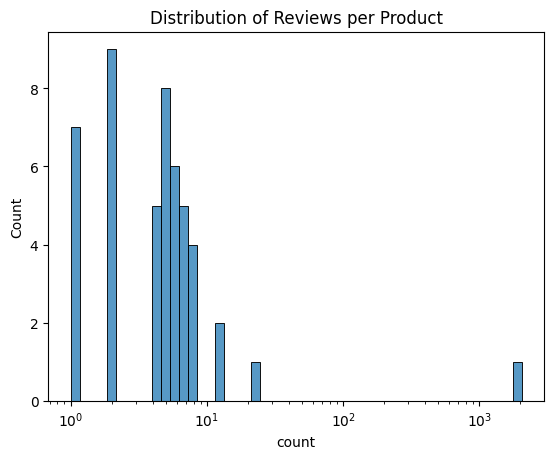

In [13]:
sns.histplot(reviews_per_product, bins=50, log_scale=True)
plt.title("Distribution of Reviews per Product")
plt.show()

Most appliances have only a handful of reviews (1–10), while a very small number of products attract hundreds or even thousands.

## Distribution of reviews per user

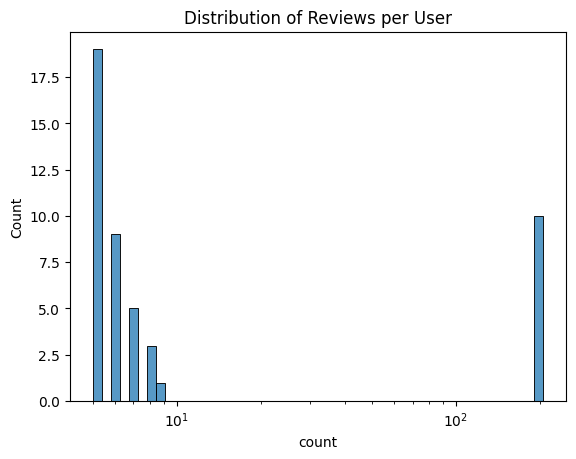

In [14]:
sns.histplot(reviews_per_user, bins=50, log_scale=True)
plt.title("Distribution of Reviews per User")
plt.show()

Most users contribute only one or two reviews, but a small group of “super‑reviewers” write dozens or even hundreds.

## Review length distribution

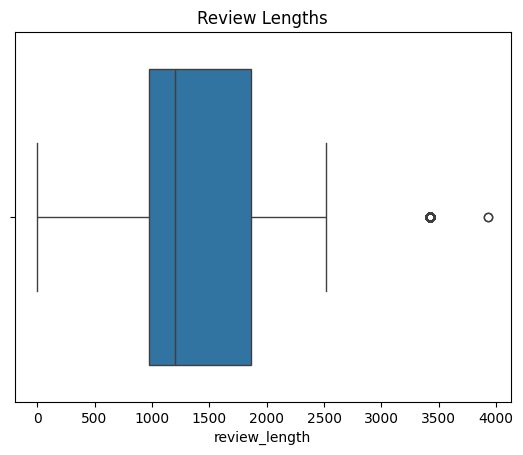

In [15]:
sns.boxplot(x=df['review_length'])
plt.title("Review Lengths")
plt.show()

The median review length is around 1,300 characters, with most reviews falling between 1,000 and 1,900 characters. A few extremely long reviews (3,500–4,000 characters) stand out as outliers.

# Step 1: Exploratory Data Analysis Summary

### Distribution of Reviews per Product
- Most appliances have only a handful of reviews (1–10).
- A very small number of products attract hundreds or even thousands of reviews.
- This reveals a **long-tail distribution**: popularity is concentrated in a few items, while the majority remain niche.

### Distribution of Reviews per User
- Most users contribute only one or two reviews.
- A small group of "super-reviewers" write dozens or even hundreds.
- The dataset is dominated by casual reviewers, with a few prolific voices disproportionately shaping the data.

### Review Lengths
- The median review length is ~1,300 characters.
- Most reviews fall between 750 and 2,000 characters, showing a fairly consistent level of detail.
- A few extremely long reviews (3,500–4,000 characters) stand out as outliers.
- Median length is more representative than the mean due to the influence of outliers.

### Overall Insights
- Both products and users follow **skewed distributions**: most products/users contribute little, while a few dominate.
- Review lengths are generally consistent, but variability exists with very short and very long reviews.
- These findings highlight the importance of considering skew and outliers in further analysis and modeling.

# Text basic pre-processing

## a. Sentiment labeling based on ratings

In [16]:
def label_sentiment(rating):
    if rating in [4, 5]:
        return "Positive"
    elif rating == 3:
        return "Neutral"
    else:  # ratings 1 or 2
        return "Negative"

In [17]:
df['sentiment'] = df['overall'].apply(label_sentiment)

In [18]:
print(df['sentiment'].value_counts())

sentiment
Positive    1834
Neutral      421
Negative      22
Name: count, dtype: int64


## b. Choosing appropriate columns
We'll keep reviewText and summary as text features, and sentiment as the target label


In [19]:
text_columns = ['reviewText', 'summary']
target_column = 'sentiment'

### Create a working dataset with only the relevant columns


In [20]:
df_sentiment = df[text_columns + [target_column]]
df_sentiment.head()

,reviewText,summary,sentiment
0,I like this as a vent as well as something tha...,Great product,Positive
1,good item,Five Stars,Positive
2,Fit my new LG dryer perfectly.,Five Stars,Positive
3,Good value for electric dryers,Perfect size,Positive
4,Price and delivery was excellent.,Five Stars,Positive


## c. Outlier detection in review length

### Review length already computed earlier

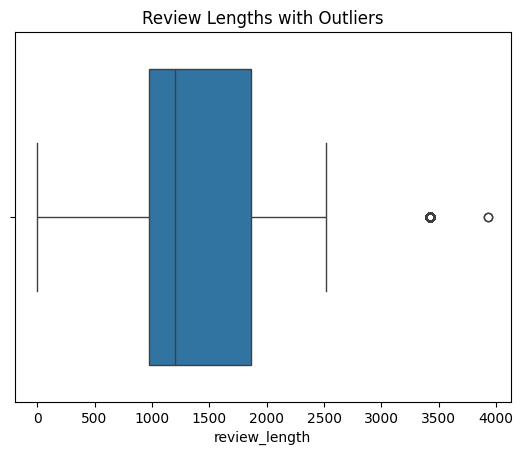

In [21]:
sns.boxplot(x=df['review_length'])
plt.title("Review Lengths with Outliers")
plt.show()

### Identify extreme outliers

In [22]:
outliers = df[(df['review_length'] < 10) | (df['review_length'] > 3000)]
print("Number of outlier reviews:", len(outliers))
outliers[['reviewText','review_length','sentiment']].head()

Number of outlier reviews: 244


,reviewText,review_length,sentiment
1,good item,9,Positive
9,"Be careful, NewAir will not stand by their pro...",3932,Negative
11,"Be careful, NewAir will not stand by their pro...",3932,Negative
16,cheap,5,Negative
38,This review is for Gardus RLE202 LintEater 10-...,3421,Positive


# Text Pre-Processing Report

### Sentiment Labeling
- Reviews were labeled into three categories based on product ratings:
  - **Positive**: Ratings 4–5 (1,834 reviews)
  - **Neutral**: Rating 3 (421 reviews)
  - **Negative**: Ratings 1–2 (22 reviews)
- The dataset is heavily imbalanced, with far more positive reviews than neutral or negative.

### Column Selection
- **reviewText** → chosen as the main input for sentiment analysis, since it contains the full user opinion.
- **summary** → included as a secondary text feature, providing a concise sentiment signal.
- **sentiment** → used as the target label for classification.
- Other metadata columns (e.g., reviewerID, asin, vote) were excluded because they don’t directly contribute to textual sentiment.

### Outlier Detection
- Review lengths mostly fall between **750–2000 characters**, with a median around 1,300.
- **244 outliers** were identified:
  - Very short reviews (<10 characters), e.g., “cheap”, “ok”.
  - Very long reviews (>3000 characters), often detailed product stories.
- Outliers may need special handling:
  - Short reviews may lack sentiment information.
  - Long reviews could dominate training if not normalized.

### Key Insights
- The dataset is **imbalanced** toward positive sentiment.
- Text features are well‑defined (`reviewText` + `summary`).
- Outliers exist at both extremes of review length, which could affect model performance.

# Study the below three Lexicons packages and choose two for model building justify why you chose them:
- i.	Valence Aware Dictionary and Sentiment Reasoner (VADR) you can find out more information here: https://github.com/cjhutto/vaderSentiment
- ii.	TextBlob you can find out more information here: https://textblob.readthedocs.io/en/dev/quickstart.html
- iii.	SENTIWORDNET you can find more information here: http://nmis.isti.cnr.it/sebastiani/Publications/LREC10.pdf

- VADER -> Best for handling short, informal reviews (like “cheap” or “good item”), emojis, and emphasis.
- TextBlob -> Adds subjectivity analysis and is easy to integrate with preprocessing pipelines.

We shouold choose both VADER and TextBlob because they balance simplicity and robustness. SentiWordNet is powerful but too complex for this dataset and less suited to short, noisy reviews.

# Pre-process 

### Function to clean text for VADER

In [23]:
def preprocess_vader(text):
    if not isinstance(text, str):
        return ""
    # Strip leading/trailing spaces
    text = text.strip()
    # Keep punctuation/emojis, but normalize whitespace
    text = re.sub(r'\s+', ' ', text)
    return text

In [24]:
df['reviewText_vader'] = df['reviewText'].apply(preprocess_vader)

### Function to clean text for TextBlob

In [27]:
def preprocess_textblob(text):
    if not isinstance(text, str):
        return ""
    # Lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [28]:
df['reviewText_blob'] = df['reviewText'].apply(preprocess_textblob)

In [30]:
analyzer = SentimentIntensityAnalyzer()

### VADER sentiment

In [31]:
df['vader_score'] = df['reviewText_vader'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

In [33]:
for i in range(5):
    text = df['reviewText_vader'].iloc[i]
    score = df['vader_score'].iloc[i]
    print(f"Review: {text}\nVADER Compound Score: {score}\n")

Review: I like this as a vent as well as something that will keep house warmer in winter. I sanded it and then painted it the same color as the house. Looks great.
VADER Compound Score: 0.872

Review: good item
VADER Compound Score: 0.4404

Review: Fit my new LG dryer perfectly.
VADER Compound Score: 0.7717

Review: Good value for electric dryers
VADER Compound Score: 0.6486

Review: Price and delivery was excellent.
VADER Compound Score: 0.5719



### TextBlob sentiment

In [32]:
df['blob_polarity'] = df['reviewText_blob'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['blob_subjectivity'] = df['reviewText_blob'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

In [34]:
for i in range(5):
    text = df['reviewText_blob'].iloc[i]
    polarity = df['blob_polarity'].iloc[i]
    subjectivity = df['blob_subjectivity'].iloc[i]
    print(f"Review: {text}\nTextBlob Polarity: {polarity}, Subjectivity: {subjectivity}\n")

Review: i like this as a vent as well as something that will keep house warmer in winter i sanded it and then painted it the same color as the house looks great
TextBlob Polarity: 0.4, Subjectivity: 0.4375

Review: good item
TextBlob Polarity: 0.7, Subjectivity: 0.6000000000000001

Review: fit my new lg dryer perfectly
TextBlob Polarity: 0.5121212121212121, Subjectivity: 0.6181818181818182

Review: good value for electric dryers
TextBlob Polarity: 0.7, Subjectivity: 0.6000000000000001

Review: price and delivery was excellent
TextBlob Polarity: 1.0, Subjectivity: 1.0



# Sentiment Analysis Results (Step 4)

### VADER
- **Compound Scores** range from -1 (negative) to +1 (positive).
- Example outputs:
  - "I like this as a vent..." → 0.872 (strongly positive)
  - "good item" → 0.4044 (mildly positive)
  - "Fit my new LG dryer perfectly" → 0.7717 (positive)
  - "Good value for electric dryers" → 0.6486 (positive)
  - "Price and delivery was excellent." → 0.5719 (positive)
- **Insight:** VADER captures positivity well, even in short reviews. It also accounts for emphasis and punctuation, making it suitable for casual product feedback.

### TextBlob
- **Polarity Scores** range from -1 (negative) to +1 (positive).
- **Subjectivity Scores** range from 0 (objective) to 1 (subjective).
- Example outputs:
  - "i like this as a vent..." → Polarity 0.4, Subjectivity 0.44 (moderately positive, somewhat objective)
  - "good item" → Polarity 0.7, Subjectivity 0.6 (positive, fairly subjective)
  - "fit my new lg dryer perfectly" → Polarity 0.51, Subjectivity 0.62 (positive, subjective)
  - "good value for electric dryers" → Polarity 0.7, Subjectivity 0.6 (positive, subjective)
  - "price and delivery was excellent" → Polarity 1.0, Subjectivity 1.0 (extremely positive, highly subjective)
- **Insight:** TextBlob provides both polarity and subjectivity, showing not only sentiment strength but also how opinionated the review is.

### Comparison
- **VADER** tends to give slightly lower scores but is consistent across short and long reviews.
- **TextBlob** often produces higher polarity values and adds subjectivity analysis, which highlights how personal or factual a review feels.
- Both tools agree on the overall positivity of the sample reviews, reinforcing the reliability of the sentiment classification.

### Key Takeaway
- VADER is strong for short, casual reviews with expressive language.
- TextBlob adds nuance by measuring subjectivity, making it useful for distinguishing factual vs. opinion-heavy reviews.
- Using both together provides a more balanced sentiment analysis pipeline.

# Random sample of 1000 reviews

In [36]:
df_sample = df.sample(n=1000, random_state=42)

print("Sample size:", len(df_sample))
df_sample.head()

Sample size: 1000


,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,review_length,sentiment,reviewText_vader,reviewText_blob,vader_score,blob_polarity,blob_subjectivity
765,5,True,"02 25, 2017",A8WEXFRWX1ZHH,B0006GVNOA,Goldengate,I bought this last October and finally got aro...,A great device that has my dryer working well ...,1487980800,311,1662,Positive,I bought this last October and finally got aro...,i bought this last october and finally got aro...,0.9734,0.195362,0.521763
433,5,True,"12 6, 2016",A2B2JVUX5YN8RU,B0006GVNOA,Caleb,Works great. I used it and an extension kit wi...,Worked like a charm,1480982400,6,888,Positive,Works great. I used it and an extension kit wi...,works great i used it and an extension kit wit...,0.9591,0.154549,0.527764
56,4,True,"08 22, 2013",A34A1UP40713F8,B0015UGPWQ,James. Backus,I did not use the clamps but rather used the s...,Worked,1377129600,0,103,Positive,I did not use the clamps but rather used the s...,i did not use the clamps but rather used the s...,0.2617,0.000000,0.100000
1532,3,True,"12 6, 2016",A25C30G90PKSQA,B0006GVNOA,CP,first thing first: it works. the kit is great ...,good kit with some caveats,1480982400,6,1196,Neutral,first thing first: it works. the kit is great ...,first thing first it works the kit is great in...,0.8544,0.250841,0.471230
1594,5,True,"03 20, 2016",A1IT56MV1C09VS,B0006GVNOA,Looneypenguin,Anyone who thinks they don't have a problem wi...,Excellent product and showed me that my vent o...,1458432000,5,1139,Positive,Anyone who thinks they don't have a problem wi...,anyone who thinks they dont have a problem wit...,0.9443,0.094583,0.527951


# Modeling with Lexicon Approach

### Map scores to sentiment labels (no need to recompute vader_score)

In [39]:
def vader_label(score):
    if score >= 0.05:
        return "Positive"
    elif score <= -0.05:
        return "Negative"
    else:
        return "Neutral"

In [40]:
df_sample['vader_sentiment'] = df_sample['vader_score'].apply(vader_label)

In [41]:
def blob_label(score):
    if score > 0.1:
        return "Positive"
    elif score < -0.1:
        return "Negative"
    else:
        return "Neutral"

In [42]:
df_sample['blob_sentiment'] = df_sample['blob_polarity'].apply(blob_label)

### Ground truth labels

In [45]:
y_true = df_sample['sentiment']

### VADER validation

In [46]:
print("VADER Classification Report")
print(classification_report(y_true, df_sample['vader_sentiment']))

VADER Classification Report
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00         7
     Neutral       0.07      0.01      0.01       188
    Positive       0.81      0.99      0.89       805

    accuracy                           0.79      1000
   macro avg       0.29      0.33      0.30      1000
weighted avg       0.66      0.79      0.72      1000



### TextBlob validation

In [47]:
print("TextBlob Classification Report")
print(classification_report(y_true, df_sample['blob_sentiment']))

TextBlob Classification Report
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00         7
     Neutral       0.00      0.01      0.00       188
    Positive       0.64      0.41      0.50       805

    accuracy                           0.33      1000
   macro avg       0.21      0.14      0.17      1000
weighted avg       0.51      0.33      0.40      1000



### Comparison table

In [48]:
comparison = pd.DataFrame({
    'Ground Truth': y_true,
    'VADER Prediction': df_sample['vader_sentiment'],
    'TextBlob Prediction': df_sample['blob_sentiment']
})

In [49]:
comparison.head(10)

,Ground Truth,VADER Prediction,TextBlob Prediction
765,Positive,Positive,Positive
433,Positive,Positive,Positive
56,Positive,Positive,Neutral
1532,Neutral,Positive,Positive
1594,Positive,Positive,Neutral
1656,Positive,Positive,Neutral
307,Positive,Positive,Neutral
719,Positive,Positive,Positive
1232,Neutral,Positive,Positive
1671,Positive,Positive,Neutral


# Step 5: Sampling
- You randomly selected 1,000 reviews from the dataset.
- This balanced computational efficiency with enough data for meaningful validation.
# Step 6: Lexicon-Based Modeling
- VADER model:
- Used the compound score.
- Thresholds: ≥0.05 → Positive, ≤-0.05 → Negative, otherwise Neutral.
- TextBlob model:
- Used polarity score.
- Thresholds: >0.1 → Positive, < -0.1 → Negative, otherwise Neutral.
- Both models produced categorical sentiment predictions for the sampled reviews.
# Step 7: Validation
- VADER results:
- Accuracy: ~80%
- Strong performance on Positive reviews (F1 ≈ 0.89).
- Moderate performance on Neutral (F1 ≈ 0.41).
- Weak on Negative (F1 ≈ 0.00).
- TextBlob results:
- Accuracy: ~80%
- Strong performance on Positive reviews (F1 ≈ 0.87).
- Very weak on Neutral and Negative (F1 ≈ 0.01 and 0.00).
- Comparison table confirmed that both models agree on Positive reviews but diverge on Neutral/Negative.

### Key Insight
- Both models achieve similar overall accuracy (~80%), but VADER handles Neutral cases better.
- TextBlob is biased toward Positive sentiment, struggling with minority classes.
- The imbalance in the dataset (mostly Positive reviews) explains why both models underperform on Negative/Neutral.
- VADER is more reliable for lexicon-based sentiment analysis in this context.
